## Machine Learning Using Decision Trees and Random Forests

### Data: Breast Cancer Wisconsin Diagnostic

We are going to be using Machine Learning (Decision Trees and Random Forests) to diagnose patients based on the data

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

In [103]:
# Import the Data
data = pd.read_csv('../input/data.csv')

In [104]:
# Explore the Data
data.head(8)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN


In [105]:
data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


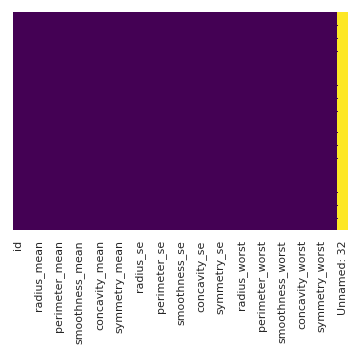

In [106]:
# Check for missing values
sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [107]:
# Delete the empty column
data.drop('Unnamed: 32', axis = 1, inplace = True)

There are now no missing values in the data

### Data Visualization

Text(0.5, 1.0, 'Diagnosis Distribution')

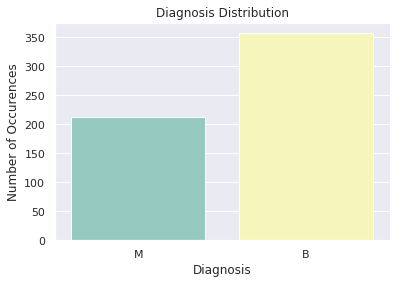

In [108]:
# Visualize the data
sns.set(style = 'darkgrid')
g = sns.countplot(x = "diagnosis", data = data, palette = "Set3")
plt.ylabel("Number of Occurences")
plt.xlabel("Diagnosis")
plt.title("Diagnosis Distribution")

In [109]:
# drop ID column from our dataset
data.drop('id', axis = 1, inplace = True)

We have 30 variables

It is going to be easier to visualize them in smaller groups

In [110]:
data.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [111]:
# Create groups of some variables we want to visualize
means = data[['diagnosis', 'radius_mean', 'texture_mean', 'radius_worst', 'texture_worst']]

means2 = data[['diagnosis', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean']]

means3 = data[['diagnosis', 'concave points_mean', 'fractal_dimension_mean']]

In [112]:
# Use pd.melt to be able to visualize multiple variables at once
melt_means = pd.melt(means, id_vars = 'diagnosis', var_name = "Variables", value_name = "Value")
melt_means2 = pd.melt(means2, id_vars = 'diagnosis', var_name = "Variables", value_name = "Value")
melt_means3 = pd.melt(means3, id_vars = 'diagnosis', var_name = "Variables", value_name = "Value")

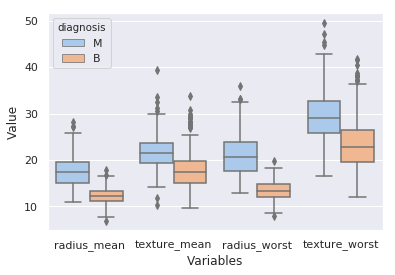

In [113]:
# Boxplots
sns.boxplot(x = "Variables", y = "Value", data = melt_means, hue = 'diagnosis', palette = 'pastel')

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

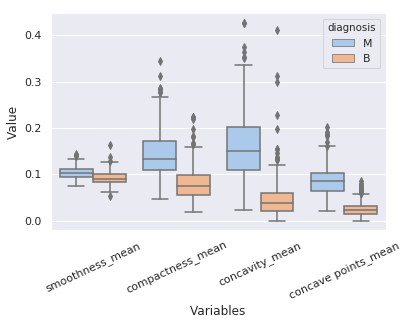

In [114]:
sns.boxplot(x = "Variables", y = "Value", 
            data = melt_means2, hue = 'diagnosis', 
            palette = 'pastel')

plt.xticks(rotation=25)

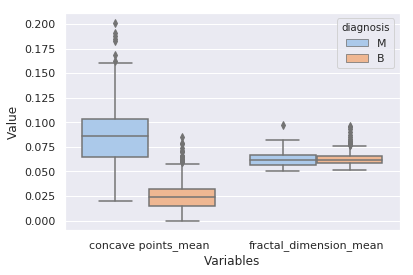

In [115]:
sns.boxplot(x = "Variables", y = "Value", data = melt_means3, hue = 'diagnosis', palette = 'pastel')

There are definitely some significant differences in values between M and B groups

Let's try different kinds of plots to explore the data a little more

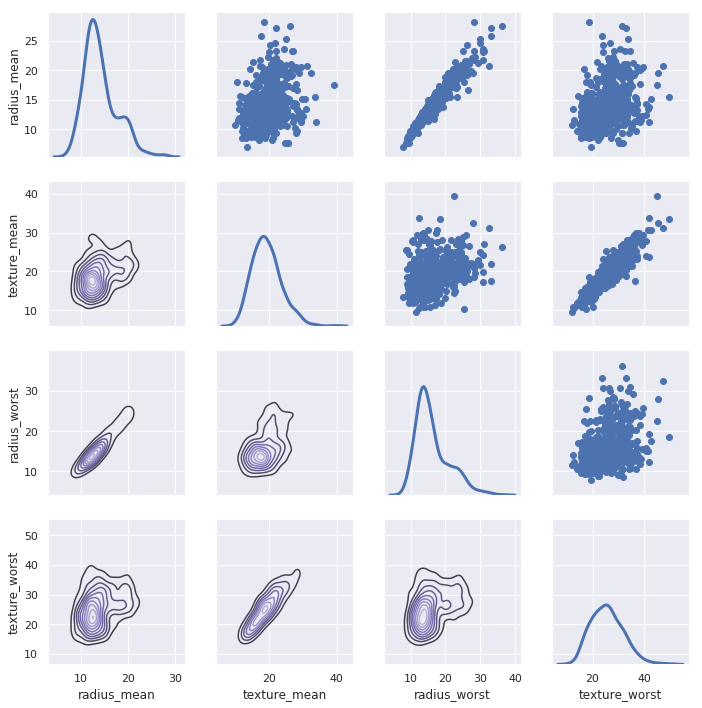

In [116]:
# We can also see the relationship between multiple variables at once
f = sns.PairGrid(means)
f = f.map_upper(plt.scatter)
f = f.map_lower(sns.kdeplot, cmap = "Purples_d")
f = f.map_diag(sns.kdeplot, lw = 3, legend = False)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

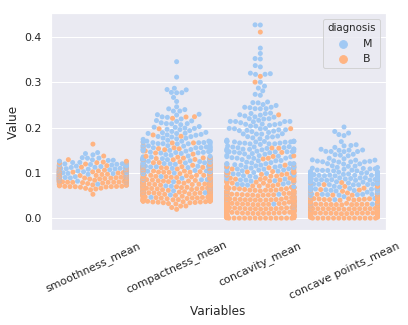

In [117]:
c = sns.swarmplot(x = "Variables", y = "Value", data = melt_means2, hue = 'diagnosis', palette = 'pastel')
plt.xticks(rotation=25)

You can see the B values being smaller than the M values very clearly here

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

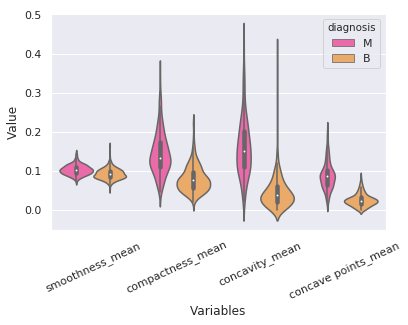

In [118]:
# Violin plots
cv = sns.violinplot(x = "Variables", y = "Value", data = melt_means2, hue = 'diagnosis', palette = 'spring')
plt.xticks(rotation=25)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

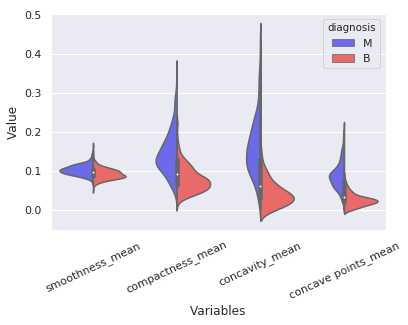

In [119]:
cv = sns.violinplot(x = "Variables", y = "Value", data = melt_means2, hue = 'diagnosis', palette = 'seismic', split = True)
plt.xticks(rotation=25)

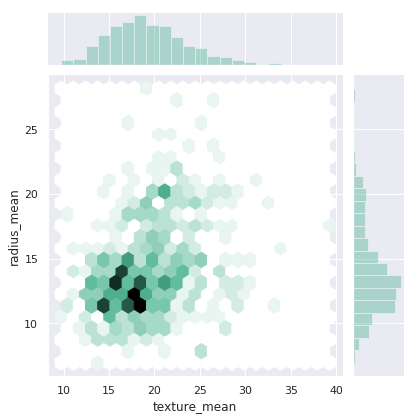

In [120]:
# If we want to see any specific relationships, we can use this:
sns.jointplot(x = 'texture_mean', y = 'radius_mean', data = means, kind = 'hex', color = "#4CB391")

Lastly, let's see how all variable scorrelate to one another

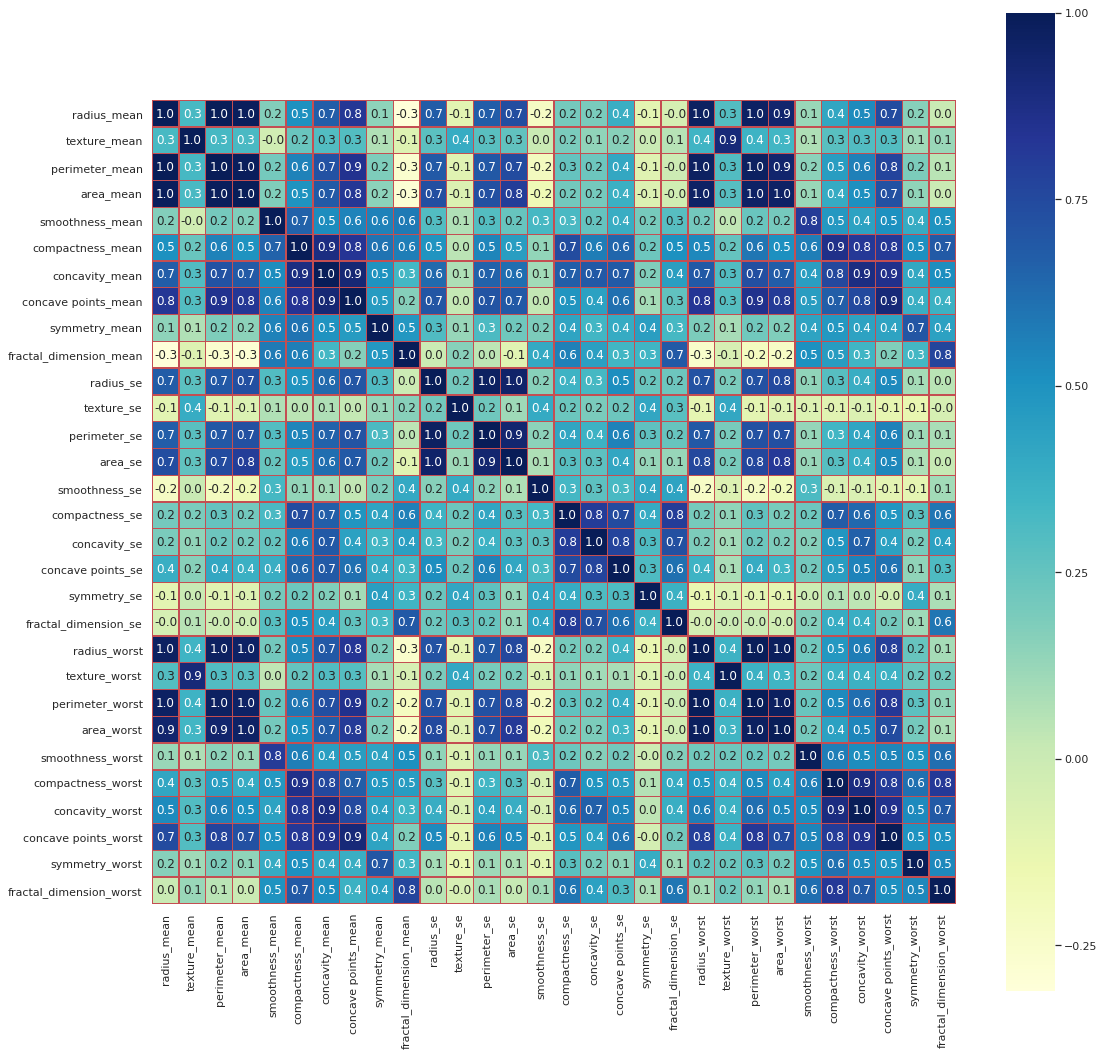

In [121]:
corrmat = data.corr()
fig, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(corrmat, square = True, cmap = "YlGnBu", annot = True, fmt = '.1f', linewidths = .25, linecolor = 'r')

That's enough visualization

## Model Building

### Feature Selection

First, let's see which variables are going to be included in our model

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [123]:
# Prepare the data
X = data.drop('diagnosis', axis = 1)
y = data['diagnosis']

In [124]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [125]:
# Feature Selection
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [126]:
# Check which features were selected to be the best to use
sel.get_support()

array([False, False,  True,  True, False, False,  True,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True, False,  True,  True, False, False, False,
        True, False, False])

In [127]:
selected_feat = X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean',
       'area_se', 'radius_worst', 'perimeter_worst', 'area_worst',
       'concave points_worst'],
      dtype='object')


### Refit the model with new features

In [128]:
X = data[['radius_mean', 'perimeter_mean', 'area_mean', 'concave points_mean',
       'radius_worst', 'perimeter_worst', 'area_worst',
       'concave points_worst']]

y = data['diagnosis']

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [130]:
dtree = DecisionTreeClassifier()

In [131]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [132]:
# Predict values based on selected model
predictions = dtree.predict(X_test)

In [133]:
# Check how the well the model did
from sklearn.metrics import classification_report, confusion_matrix

In [134]:
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[91  4]
 [ 9 67]]


              precision    recall  f1-score   support

           B       0.91      0.96      0.93        95
           M       0.94      0.88      0.91        76

   micro avg       0.92      0.92      0.92       171
   macro avg       0.93      0.92      0.92       171
weighted avg       0.92      0.92      0.92       171



92% acuuracy - Not too great but not too bad

## Random Forests

The dataset is fairly big, we can assume that Random Forests is going to do a better job here

Let's try to fit a model using random forests

In [135]:
rfc = RandomForestClassifier(n_estimators = 100)

In [136]:
# Fit the model
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [137]:
# Predict values
rfc_pred = rfc.predict(X_test)

In [138]:
# Check accuracy
print(confusion_matrix(y_test, rfc_pred))
print('\n')
print(classification_report(y_test, rfc_pred))

[[94  1]
 [ 7 69]]


              precision    recall  f1-score   support

           B       0.93      0.99      0.96        95
           M       0.99      0.91      0.95        76

   micro avg       0.95      0.95      0.95       171
   macro avg       0.96      0.95      0.95       171
weighted avg       0.96      0.95      0.95       171



Sure enough!

We get 96% accuracy.

As expected, random forests did a better job.

## Thanks for checking this out